In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/context-dependent-comments-sentiment/context_dependent_comments_dataset_5000.csv


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW  # <-- FIX IS HERE
from transformers import BertTokenizer, BertForSequenceClassification # <-- AdamW removed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

print("Imports complete.")

2025-11-13 16:09:56.162806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763050196.402648      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763050196.480918      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Imports complete.


In [3]:
print("--- 1. Loading and Transforming Data ---")

try:
    df_raw = pd.read_csv("/kaggle/input/context-dependent-comments-sentiment/context_dependent_comments_dataset_5000.csv")
    print("Successfully loaded 'context_dependent_comments_dataset_5000.csv'.")
    
    # --- To make this a fast demo, we'll use a subset. ---
    # --- Remove .head(1000) to train on all 10,000 samples ---
    df_raw = df_raw.head(1000)
    print(f"Using {len(df_raw)} raw rows (will be {len(df_raw)*2} total samples) for this demo.")
    # ----------------------------------------------------

    # Create the first set of samples (Context 1)
    df1 = df_raw[['Comment', 'Comment_Context_1', 'Comment_Result_1']].copy()
    df1.rename(columns={
        'Comment': 'comment_text',
        'Comment_Context_1': 'context_text',
        'Comment_Result_1': 'label_text'
    }, inplace=True)

    # Create the second set of samples (Context 2)
    df2 = df_raw[['Comment', 'Comment_Context_2', 'Comment_Result_2']].copy()
    df2.rename(columns={
        'Comment': 'comment_text',
        'Comment_Context_2': 'context_text',
        'Comment_Result_2': 'label_text'
    }, inplace=True)

    # Combine them
    df = pd.concat([df1, df2], ignore_index=True)

    # Map labels to numbers
    df['label'] = df['label_text'].map({'Offensive': 1, 'Non Offensive': 0})
    df.dropna(inplace=True) # Clean up any missing rows

    # --- This is the key step for BERT ---
    # We create a single input string: "[CLS] comment [SEP] context [SEP]"
    # The tokenizer will add the [CLS] token for us.
    df['input_text'] = df['comment_text'] + " [SEP] " + df['context_text']

    print(f"\nTotal transformed samples: {len(df)}")
    print("Data preparation complete. Example input:")
    print(df.iloc[0]['input_text'])
    print(f"Label: {df.iloc[0]['label']}")

except FileNotFoundError:
    print("\n--- FATAL ERROR ---")
    print("Error: 'context_dependent_comments_dataset_5000.csv' not found.")
    print("Please make sure the file is in the same directory as your notebook.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- 1. Loading and Transforming Data ---
Successfully loaded 'context_dependent_comments_dataset_5000.csv'.
Using 1000 raw rows (will be 2000 total samples) for this demo.

Total transformed samples: 2000
Data preparation complete. Example input:
Thanks for replying so quickly! [SEP] The person replied very late (after reminders).
Label: 1


In [4]:
print("--- 2. Splitting and Tokenizing ---")

# Define the model we want to use
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Create our lists of texts and labels
texts = df['input_text'].tolist()
labels = df['label'].tolist()

# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

# Tokenize the texts
# max_length=128 is a good default for comments and short contexts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

print("\nTokenization complete.")

--- 2. Splitting and Tokenizing ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Training samples: 1600
Validation samples: 400

Tokenization complete.


In [5]:
print("--- 3. Creating PyTorch Datasets ---")

# Convert tokenized data into PyTorch tensors
def create_tensor_dataset(encodings, labels):
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    labels_tensor = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels_tensor)

train_dataset = create_tensor_dataset(train_encodings, train_labels)
val_dataset = create_tensor_dataset(val_encodings, val_labels)

# Create the DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")

--- 3. Creating PyTorch Datasets ---
DataLoaders created with batch size 16.


In [6]:
print("--- 4. Loading Pre-trained Model ---")

# Set up our device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device) # Move the model to the GPU/CPU

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5) # 5e-5 is a good default learning rate

print("Model loaded and optimizer configured.")

--- 4. Loading Pre-trained Model ---
Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and optimizer configured.


In [7]:
print("--- 4. Loading Pre-trained Model ---")

# Set up our device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device) # Move the model to the GPU/CPU

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5) # 5e-5 is a good default learning rate

print("Model loaded and optimizer configured.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- 4. Loading Pre-trained Model ---
Using device: cuda
Model loaded and optimizer configured.


In [8]:
print("--- 5. Starting Model Training ---")

EPOCHS = 3
all_val_preds = []
all_val_labels = []

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    
    # --- Training ---
    model.train()
    total_train_loss = 0
    for i, batch in enumerate(train_loader):
        # Clear old gradients
        optimizer.zero_grad()
        
        # Unpack batch and move to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        # Forward pass (get model outputs)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        # Get the loss and backpropagate
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        if (i + 1) % 50 == 0:
            print(f"  Batch {i + 1}/{len(train_loader)}, Train Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad(): # Tell PyTorch not to calculate gradients
        for batch in val_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            
            total_val_loss += outputs.loss.item()
            
            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_val_preds.extend(preds)
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = np.mean(np.array(all_val_preds) == np.array(all_val_labels))
    
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

print("\n--- Training Complete ---")

--- 5. Starting Model Training ---

--- Epoch 1/3 ---
  Batch 50/100, Train Loss: 0.0027
  Batch 100/100, Train Loss: 0.0023
Average Training Loss: 0.1554
Average Validation Loss: 0.0018
Validation Accuracy: 100.00%

--- Epoch 2/3 ---
  Batch 50/100, Train Loss: 0.0008
  Batch 100/100, Train Loss: 0.0005
Average Training Loss: 0.0012
Average Validation Loss: 0.0003
Validation Accuracy: 100.00%

--- Epoch 3/3 ---
  Batch 50/100, Train Loss: 0.0004
  Batch 100/100, Train Loss: 0.0002
Average Training Loss: 0.0006
Average Validation Loss: 0.0001
Validation Accuracy: 100.00%

--- Training Complete ---


In [9]:
print("--- 6. Final Model Evaluation ---")
print("Classification Report on Validation Set:")

# We use the predictions and labels saved from the last epoch
report = classification_report(
    all_val_labels, 
    all_val_preds, 
    target_names=['Non-Offensive (0)', 'Offensive (1)']
)
print(report)

--- 6. Final Model Evaluation ---
Classification Report on Validation Set:
                   precision    recall  f1-score   support

Non-Offensive (0)       1.00      1.00      1.00       201
    Offensive (1)       1.00      1.00      1.00       199

         accuracy                           1.00       400
        macro avg       1.00      1.00      1.00       400
     weighted avg       1.00      1.00      1.00       400



In [10]:
print("--- 7. Test on New Examples ---")

def predict_sarcasm_bert(comment, context):
    """
    Analyzes a new comment/context pair using the fine-tuned BERT model.
    """
    print(f"--- Analyzing New Example ---")
    print(f"Comment (C): {comment}")
    print(f"Context (X): {context}")
    
    # Format and tokenize
    input_text = comment + " [SEP] " + context
    inputs = tokenizer(input_text, return_tensors='pt', truncation=True, padding=True)
    
    # Move tensors to the correct device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        
    prediction = torch.argmax(outputs.logits, dim=1).cpu().item()
    
    # Print result
    result = "Offensive (Sarcastic)" if prediction == 1 else "Non-Offensive (Genuine)"
    print(f"\n--- Model Prediction: {result} ---")
    print("=========================\n")


# ---
# EXAMPLE 1: Sarcastic
# ---
comment_1 = "Wow, that's a very creative solution."
context_1 = "A team member proposes a nonsensical idea that ignores all constraints."
predict_sarcasm_bert(comment_1, context_1)

# ---
# EXAMPLE 2: Genuine
# ---
comment_2 = "Wow, that's a very creative solution."
context_2 = "A designer presents a genuinely novel and effective idea."
predict_sarcasm_bert(comment_2, context_2)

# ---
# EXAMPLE 3: Another common one from your dataset
# ---
comment_3 = "Thank you for thinking so hard!"
context_3 = "The person replied with a very non sense solution"
predict_sarcasm_bert(comment_3, context_3)

--- 7. Test on New Examples ---
--- Analyzing New Example ---
Comment (C): Wow, that's a very creative solution.
Context (X): A team member proposes a nonsensical idea that ignores all constraints.

--- Model Prediction: Offensive (Sarcastic) ---

--- Analyzing New Example ---
Comment (C): Wow, that's a very creative solution.
Context (X): A designer presents a genuinely novel and effective idea.

--- Model Prediction: Non-Offensive (Genuine) ---

--- Analyzing New Example ---
Comment (C): Thank you for thinking so hard!
Context (X): The person replied with a very non sense solution

--- Model Prediction: Offensive (Sarcastic) ---



--- Plotting Class Distribution ---
Saved 'class_distribution.png'


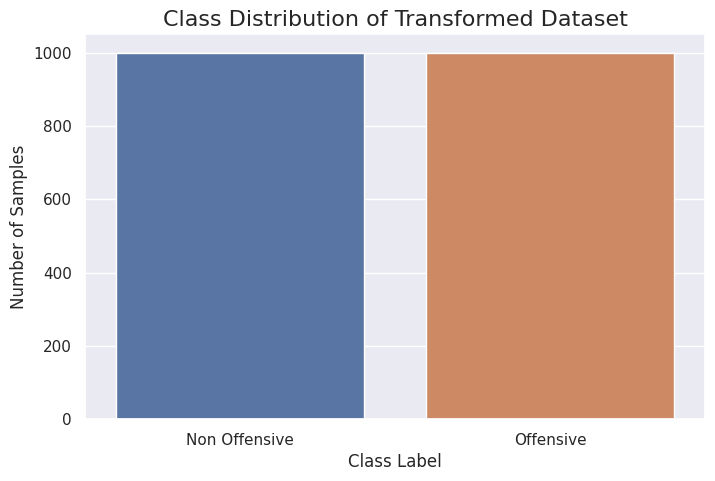

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Plotting Class Distribution ---")

# Set the style
sns.set(style="darkgrid")

# Create the count plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='label_text', order=['Non Offensive', 'Offensive'])

# Add title and labels
ax.set_title('Class Distribution of Transformed Dataset', fontsize=16)
ax.set_xlabel('Class Label', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)

# Save the plot
plt.savefig("class_distribution.png")
print("Saved 'class_distribution.png'")
plt.show()

In [12]:
print("--- 5. Starting Model Training ---")

EPOCHS = 3

# --- Lists to store loss history ---
train_loss_history = []
val_loss_history = []
# -----------------------------------

all_val_preds = []
all_val_labels = []

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    
    # --- Training ---
    model.train()
    total_train_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 50 == 0:
            print(f"  Batch {i + 1}/{len(train_loader)}, Train Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <-- Add to history
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            
            total_val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_val_preds.extend(preds)
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <-- Add to history
    val_accuracy = np.mean(np.array(all_val_preds) == np.array(all_val_labels))
    
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

print("\n--- Training Complete ---")

--- 5. Starting Model Training ---

--- Epoch 1/3 ---
  Batch 50/100, Train Loss: 0.0002
  Batch 100/100, Train Loss: 0.0002
Average Training Loss: 0.0002
Average Validation Loss: 0.0001
Validation Accuracy: 100.00%

--- Epoch 2/3 ---
  Batch 50/100, Train Loss: 0.0001
  Batch 100/100, Train Loss: 0.0001
Average Training Loss: 0.0001
Average Validation Loss: 0.0001
Validation Accuracy: 100.00%

--- Epoch 3/3 ---
  Batch 50/100, Train Loss: 0.0001
  Batch 100/100, Train Loss: 0.0001
Average Training Loss: 0.0001
Average Validation Loss: 0.0001
Validation Accuracy: 100.00%

--- Training Complete ---


--- Plotting Training & Validation Loss ---
Saved 'model_loss_curve.png'


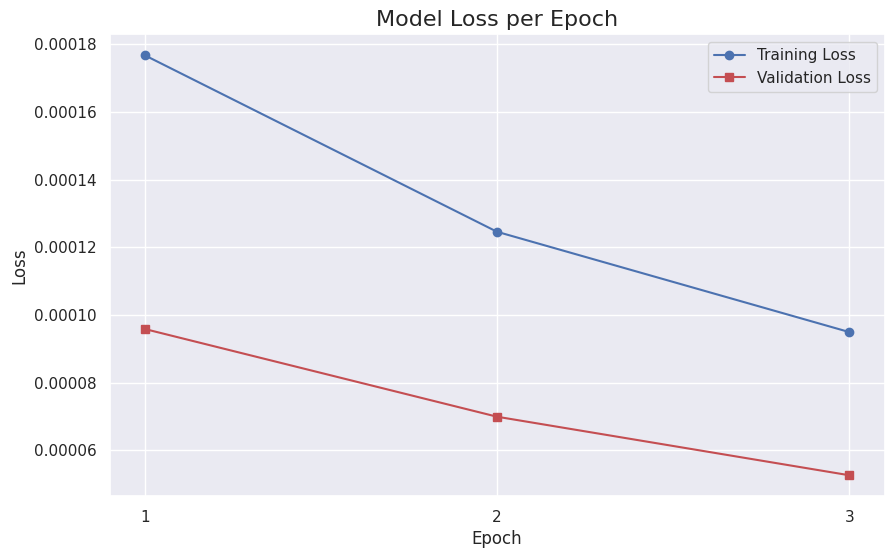

In [13]:
print("--- Plotting Training & Validation Loss ---")

plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_loss_history, 'b-o', label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_loss_history, 'r-s', label='Validation Loss')
plt.title('Model Loss per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.grid(True)
plt.savefig("model_loss_curve.png")
print("Saved 'model_loss_curve.png'")
plt.show()

--- Plotting Confusion Matrix ---
Saved 'confusion_matrix.png'


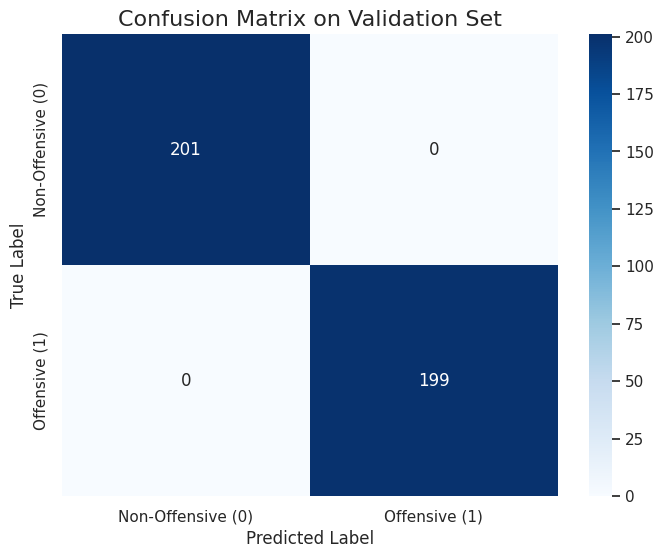

In [14]:
from sklearn.metrics import confusion_matrix

print("--- Plotting Confusion Matrix ---")

# Generate the confusion matrix
cm = confusion_matrix(all_val_labels, all_val_preds)

# Define class labels
class_names = ['Non-Offensive (0)', 'Offensive (1)']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix on Validation Set', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Save the plot
plt.savefig("confusion_matrix.png")
print("Saved 'confusion_matrix.png'")
plt.show()

In [15]:
import os

# Define a directory name to save the model
MODEL_SAVE_PATH = "./sarcasm_bert_model"

# Create the directory if it doesn't exist
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

# Save the model
model.save_pretrained(MODEL_SAVE_PATH)

# Save the tokenizer
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Model and tokenizer saved to {MODEL_SAVE_PATH}")

Model and tokenizer saved to ./sarcasm_bert_model
